**Imports**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.model_selection import train_test_split
# from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from datetime import datetime

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

from keras.layers import Input, Conv2D 
from keras.layers import MaxPool2D, Flatten, Dense 
from keras import Model

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

**Data Preprocessing**

In [2]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


# Resize the images to 48x48x1
resized_train_images = np.zeros((train_images.shape[0], 48, 48, 1))
resized_test_images = np.zeros((test_images.shape[0], 48, 48, 1))

for i in range(train_images.shape[0]):
    resized_train_images[i] = cv2.resize(train_images[i], (48, 48)).reshape(48, 48, 1)

for i in range(test_images.shape[0]):
    resized_test_images[i] = cv2.resize(test_images[i], (48, 48)).reshape(48, 48, 1)

# Normalize the pixel values to [0, 1]
resized_train_images = resized_train_images / 255.0
resized_test_images = resized_test_images / 255.0

X_t = resized_train_images
Y_t = train_labels
X_test = resized_test_images
Y_test = test_labels

Y_t = keras.utils.to_categorical(Y_t)
Y_test = keras.utils.to_categorical(Y_test)

X_train, X_val, Y_train, Y_val = train_test_split(X_t, Y_t, test_size=0.16666, random_state=42)

print("X_train shape:", X_train.shape) #(0.66*60,000)*28*28
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape) #(0.66*60,000)*28*28
print("Y_val shape:", Y_val.shape)
print("X_test  shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


11490434/11490434 [==============================] - 0s 0us/step
X_train shape: (50000, 48, 48, 1)
Y_train shape: (50000, 10)
X_val shape: (10000, 48, 48, 1)
Y_val shape: (10000, 10)
X_test  shape: (10000, 48, 48, 1)
Y_test shape: (10000, 10)


**VGG-16 Implementation**

In [3]:
def create_model(act): #'relu', 'sigmoid', 'tanh', tf.keras.layers.LeakyReLU(alpha=0.1)
  input = Input(shape =(48,48,1))

  x = Conv2D (filters =64, kernel_size =3, padding ='same', activation=act)(input)
  x = Conv2D (filters =64, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Conv2D (filters =128, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =128, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Flatten()(x)
  x = Dense(units = 4096, activation =act)(x)
  x = Dense(units = 4096, activation =act)(x)
  output = Dense(units = 10, activation ='softmax')(x)
  model = Model (inputs=input, outputs =output)

  return model

class SaveAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

In [4]:
# tf.keras.utils.plot_model( 
#     model,
#     show_shapes=True,
#     show_layer_names=True, 
# )

create_model('tanh').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                             

**Optimizers**

In [5]:
def adam_opt(model,l_rate):
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=l_rate,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

def rms_prop(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.RMSprop(
      learning_rate=l_rate,
      rho=0.9,
      epsilon=1e-07)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model
  
def momentum_gd(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.SGD(
      learning_rate=l_rate,
      momentum=0.9,
      nesterov=False) #################
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

def vanilla_gd(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.SGD(
      learning_rate=l_rate,
      momentum=0.0)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

In [6]:
model = create_model("tanh")
model = adam_opt(model,0.0001)
model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=128,epochs=10,verbose=1,shuffle=True)

    
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, val_acc = model.evaluate(X_val, Y_val, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)

print('Training  Accuracy:   %.3f' % train_acc)
print('Validation Accuracy:  %.3f' % val_acc)
print('Testing Accuracy:     %.3f' % test_acc)

Epoch 1/10
391/391 [==============================] - 38s 68ms/step - loss: 0.2003 - accuracy: 0.9351 - val_loss: 0.0884 - val_accuracy: 0.9724
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.0583 - accuracy: 0.9824 - val_loss: 0.0456 - val_accuracy: 0.9869
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.0445 - accuracy: 0.9865 - val_loss: 0.0464 - val_accuracy: 0.9866
Epoch 4/10
391/391 [==============================] - 27s 68ms/step - loss: 0.0358 - accuracy: 0.9892 - val_loss: 0.0465 - val_accuracy: 0.9870
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.0325 - accuracy: 0.9897 - val_loss: 0.0778 - val_accuracy: 0.9830
Epoch 6/10
391/391 [==============================] - 26s 66ms/step - loss: 0.0358 - accuracy: 0.9893 - val_loss: 0.0399 - val_accuracy: 0.9887
Epoch 7/10
391/391 [==============================] - 27s 68ms/step - loss: 0.0287 - accuracy: 0.9916 - val_loss: 0.0486 - val_accuracy:

**Data Preprocessing to suit for our new classification task**

In [7]:
C = [0,2,3,5,6,8,9]
S = [1,4,7]
Y_t1 = []
Y_test1 = []

for ele in train_labels:
    if ele in C:
        Y_t1.append(0)
    else:
        Y_t1.append(1)
for ele in test_labels:
    if ele in C:
        Y_test1.append(0)
    else:
        Y_test1.append(1)
        
Y_t1 = keras.utils.to_categorical(Y_t1)
Y_test1 = keras.utils.to_categorical(Y_test1)
        
X_train1, X_val1, Y_train1, Y_val1 = train_test_split(X_t, Y_t1, test_size=0.16666, random_state=42) 

X_train1 = np.array(X_train1)
X_val1 = np.array(X_val1)

Y_test1 = np.array(Y_test1,dtype = 'int32')
Y_val1 = np.array(Y_val1,dtype = 'int32')
Y_train1 = np.array(Y_train1,dtype='int32')



print("X_train shape:", X_train1.shape) #(0.66*60,000)*28*28
print("Y_train shape:", Y_train1.shape)
print("X_val shape:", X_val1.shape) #(0.66*60,000)*28*28
print("Y_val shape:", Y_val1.shape)
print("X_test  shape:", X_test.shape)
print("Y_test shape:", Y_test1.shape)

X_train shape: (50000, 48, 48, 1)
Y_train shape: (50000, 2)
X_val shape: (10000, 48, 48, 1)
Y_val shape: (10000, 2)
X_test  shape: (10000, 48, 48, 1)
Y_test shape: (10000, 2)


**Training the network**

In [8]:
pretrained_model = model

# Freeze all the layers except the last one
for layer in pretrained_model.layers[:-1]:
    layer.trainable = False
    
# Modify the last layer to have two outputs
x = pretrained_model.layers[-2].output

# Add a new dense layer with two outputs
x = Dense(2, activation='softmax')(x)

# Create a new model with the modified last layer
pretrained_model = Model(inputs=pretrained_model.input, outputs=x)

adam_opt(pretrained_model,0.0001)

history = SaveAccuracyCallback()
history.acc = []
history.val_acc = []

pretrained_model.fit(X_train1, Y_train1,validation_data=(X_val1, Y_val1),batch_size=128,epochs=10,verbose=1,shuffle=True,callbacks=[history])


_, train_acc = pretrained_model.evaluate(X_train1, Y_train1, verbose=0)
_, val_acc = pretrained_model.evaluate(X_val1, Y_val1, verbose=0)
_, test_acc = pretrained_model.evaluate(X_test, Y_test1, verbose=0)

print('Training  Accuracy:   %.3f' % train_acc)
print('Validation Accuracy:  %.3f' % val_acc)
print('Testing Accuracy:     %.3f' % test_acc)

Epoch 1/10
391/391 [==============================] - 12s 30ms/step - loss: 0.0596 - accuracy: 0.9918 - val_loss: 0.0209 - val_accuracy: 0.9949
Epoch 2/10
391/391 [==============================] - 11s 28ms/step - loss: 0.0125 - accuracy: 0.9969 - val_loss: 0.0171 - val_accuracy: 0.9952
Epoch 3/10
391/391 [==============================] - 11s 28ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0162 - val_accuracy: 0.9953
Epoch 4/10
391/391 [==============================] - 10s 25ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.0156 - val_accuracy: 0.9953
Epoch 5/10
391/391 [==============================] - 10s 26ms/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.0154 - val_accuracy: 0.9956
Epoch 6/10
391/391 [==============================] - 10s 25ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0153 - val_accuracy: 0.9957
Epoch 7/10
391/391 [==============================] - 11s 28ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0152 - val_accuracy:

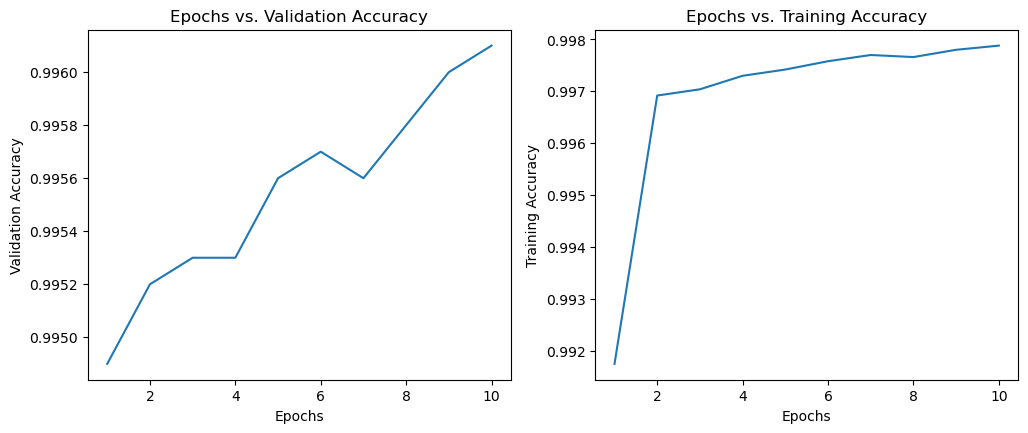

In [11]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,10+1), history.val_acc)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
        title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,10+1), history.acc)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
        title='Epochs vs. Training Accuracy')

plt.show()